In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os


print(tf.__version__)

2.3.0


# 데이터셋 만들기

In [83]:
image_datas = glob('Train2/*/*.jpg')
forders = os.listdir('Train2')
class_name = [forder for forder in forders if not '.' in forder]
dic = {"Normal" : 0,
       "abnormal" : 1}



In [84]:
image_datas

['Train2\\abnormal\\data1.jpg',
 'Train2\\abnormal\\data10.jpg',
 'Train2\\abnormal\\data100.jpg',
 'Train2\\abnormal\\data1000.jpg',
 'Train2\\abnormal\\data1001.jpg',
 'Train2\\abnormal\\data1002.jpg',
 'Train2\\abnormal\\data1003.jpg',
 'Train2\\abnormal\\data1004.jpg',
 'Train2\\abnormal\\data1005.jpg',
 'Train2\\abnormal\\data1006.jpg',
 'Train2\\abnormal\\data1007.jpg',
 'Train2\\abnormal\\data1008.jpg',
 'Train2\\abnormal\\data1009.jpg',
 'Train2\\abnormal\\data101.jpg',
 'Train2\\abnormal\\data1010.jpg',
 'Train2\\abnormal\\data1011.jpg',
 'Train2\\abnormal\\data1012.jpg',
 'Train2\\abnormal\\data1013.jpg',
 'Train2\\abnormal\\data1014.jpg',
 'Train2\\abnormal\\data1015.jpg',
 'Train2\\abnormal\\data1016.jpg',
 'Train2\\abnormal\\data1017.jpg',
 'Train2\\abnormal\\data1018.jpg',
 'Train2\\abnormal\\data1019.jpg',
 'Train2\\abnormal\\data102.jpg',
 'Train2\\abnormal\\data1020.jpg',
 'Train2\\abnormal\\data1021.jpg',
 'Train2\\abnormal\\data1022.jpg',
 'Train2\\abnormal\\data1023

In [85]:
X = []
Y = []
for imagename in image_datas:
    image = Image.open(imagename)
    image = image.resize((128,128))
    image = np.array(image)
    X.append(image)
    label = imagename.split('\\')[1]
    label = dic[label]
    Y.append(label)

In [86]:
X = np.array(X)
Y = np.array(Y)

# 데이터셋 분리

In [87]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size = 0.2, shuffle=True, random_state=33)

In [51]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size = 0.2, shuffle=True, random_state=33)
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]
train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels [..., tf.newaxis]
# tf.newaxis : 새로운 차원을 추가하여, 다른 모양의 배열간 브로드 캐스팅을 가능하게 함

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((2723, 128, 128, 3), (2723, 1), (681, 128, 128, 3), (681, 1))

In [53]:
## train set의 각 class별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (2723)), axis =-1, return_counts=True)
dict(zip(unique, counts))

{0: 1362, 1: 1361}

In [54]:
## test set의 각 class별 image수 확인
unique, counts = np.unique(np.reshape(test_labels, (681)), axis =-1, return_counts=True)
dict(zip(unique, counts))

{0: 340, 1: 341}

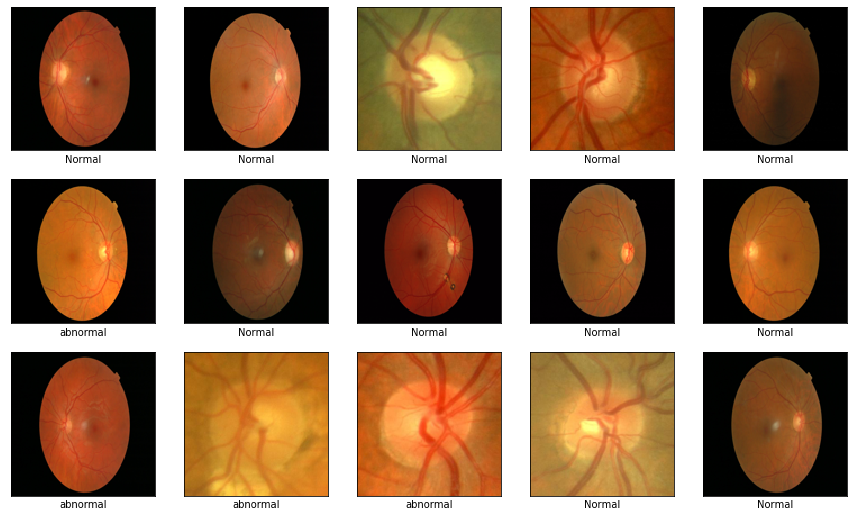

In [55]:
## Data확인
plt.figure(figsize = (15,9))
for i in range(15):
    img_idx = np.random.randint(0, N_TRAIN)
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_name[train_labels[img_idx][0]])

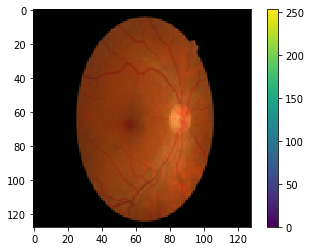

In [56]:
# 모델 훈련 전, 정확한 모델링을 위한 데이터셋 전처리
plt.figure()
plt.imshow(train_images[400])
plt.colorbar()
plt.grid(False)
plt.show()

In [91]:
## pixel값을 0~1 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.


In [102]:

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels, 2)
test_labels = keras.utils.to_categorical(test_labels, 2)

In [103]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(2903, 128, 128, 3) (2903, 2)
(726, 128, 128, 3) (726, 2)


In [94]:
## Hyper parameters

IMG_CHANNERS = 3
IMG_ROWS = 128
IMG_COLS = 128

learning_rate = 0.01
EPOCHS = 10
BATCH_SIZE = 50
CLASS = 2
steps_per_epoch = N_TRAIN//BATCH_SIZE
validation_steps = N_TEST//BATCH_SIZE
OPTIM = tf.keras.optimizers.RMSprop()

In [104]:
## dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
buffer_size = 1000).batch(BATCH_SIZE).repeat()

In [76]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

#  모델 구성


In [105]:
# CONVNET 정의
def build(input_shape, classes):
    model = models.Sequential()
    model.add(keras.layers.Conv2D(filters = 32, kernel_size = 3,
                                 activation = 'relu', padding = 'same',
                                 input_shape = input_shape))
    model.add(keras.layers.MaxPool2D(padding = 'same'))
    model.add(keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                 activation = 'relu', padding = 'same'))
    model.add(keras.layers.MaxPool2D(padding='same'))
    model.add(keras.layers.Conv2D(filters = 128, kernel_size = 3,
                                 activation = 'relu', padding = 'same'))
    model.add(keras.layers.MaxPool2D(padding='same'))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1, activation='softmax'))
    return model

In [106]:
## 모델 생성. compile and summary
model = build((IMG_ROWS, IMG_COLS, IMG_CHANNERS), CLASS)
model.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)            

In [107]:
## parameters for training
steps_per_epoch = N_TRAIN//BATCH_SIZE
validation_steps = N_TEST//BATCH_SIZE
print(steps_per_epoch, validation_steps)

54 13


In [108]:
# 텐서보드 사용
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs_Two_Class')
]

In [109]:
## Training

history = model.fit(train_images, train_labels, epochs=EPOCHS, steps_per_epoch = steps_per_epoch, validation_data = test_dataset, validation_steps = validation_steps, callbacks = callbacks)

Epoch 1/10
 6/54 [==>...........................] - ETA: 30s - loss: 7.6246 - accuracy: 0.5000

KeyboardInterrupt: 

In [24]:
socre = model.evaluate(test_dataset)
print('\nTest Score : ',socre[0])
print('Test Accuracy : ',socre[1])

15/15 [==============================] - 2s 151ms/step - loss: 0.6927 - accuracy: 0.5179

Test Score :  0.6926943063735962
Test Accuracy :  0.5179063081741333


In [25]:
test_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [26]:
Y_test = np.argmax(test_labels, axis=1)

In [27]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict_classes(test_dataset)
result = classification_report(Y_test, y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


C:\Users\YeoJunChoi\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       350
           1       0.52      1.00      0.68       376

    accuracy                           0.52       726
   macro avg       0.26      0.50      0.34       726
weighted avg       0.27      0.52      0.35       726



In [29]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                        100*np.max(predictions_array),
                                        class_name[true_label]),
                                        color = color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(CLASS), class_name, rotation=90)
    plt.yticks([])
    
    thisplot = plt.bar(range(CLASS), predictions_array, color='#777777')
    
    plt.ylim([0,1])

    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

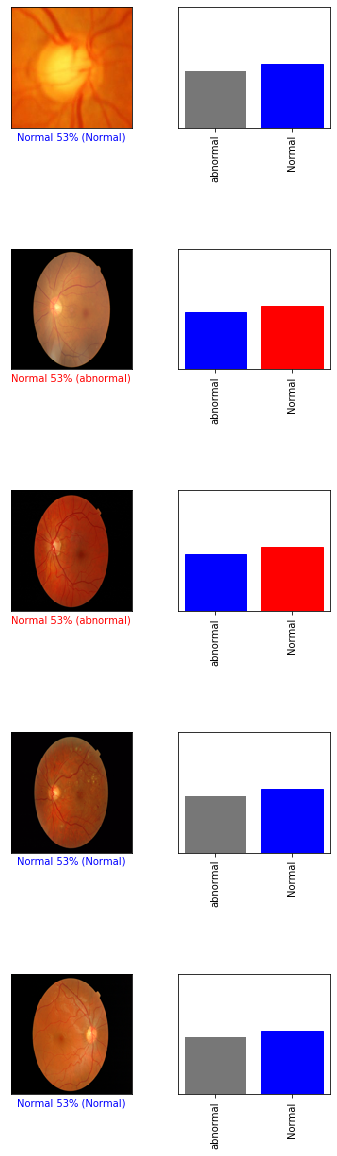

In [30]:
rnd_idx = np.random.randint(1, N_TEST//BATCH_SIZE)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt +=1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 1
    num_images = num_rows*num_cols
    
    labels = tf.argmax(labels, axis=-1)
    
    plt.figure(figsize = (3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i,predictions.numpy(), labels.numpy())
        
    break